In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input

In [96]:
parameters = ["wind_speed", "sunshine_duration",
            "pressure_air_site", "temperature_air_mean_200", "precipitation_height"]
# parameter=parameters[0]
# print(parameter)
# path="../data/weather/"+parameters[0]+"_2021.pkl"
# weather = pd.read_pickle(path)

def load_weatherdata(parameters):
    # means = pd.DataFrame()
    weather = pd.DataFrame()
    # weather_array = []
    # scaler_dict={}
    for parameter in parameters:
        path="../data/weather_all_stations/cleaned/"+parameter+".pkl"
        import_df = pd.read_pickle(path)
        index = import_df.index
        # columns = import_df.columns
        # column_list=columns.tolist()
        # scaled = pd.DataFrame(data = scaler.fit_transform(import_df), index=index, columns=columns)
        # means[parameter] = scaled.mean(axis=1)
        weather = pd.concat([weather, import_df], axis=1)
    # print(weather.head())
    import_shape=import_df.shape
    return weather, import_shape
# w2 = weather.melt(var_name='Column', value_name='Rescaled')

df, import_shape = load_weatherdata(parameters[:-1])
print(df.to_numpy().shape)
print(import_shape)
import_shape = (df.shape[0], int(df.shape[-1]/import_shape[-1]), import_shape[-1])
print(import_shape)

(17544, 528)
(17544, 132)
(17544, 4, 132)


In [97]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

c:\Users\Leon1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
c:\Users\Leon1\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


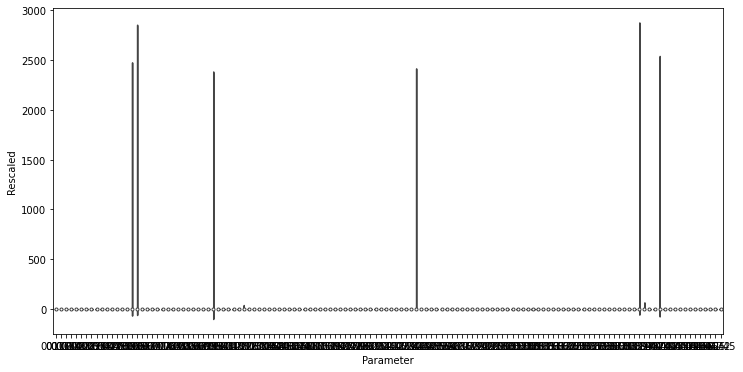

In [98]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
scaler = RobustScaler()

scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index).clip(lower=-3)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x="Parameter", y="Rescaled", data=df_train.melt(var_name='Parameter', value_name='Rescaled'))
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [40]:
X_train = df_train.to_numpy()
input_dim=df_train.shape[1]

# this fixes the latent space dimension, feel free to play around with
# the values for your own experiments, but leave it at 2 for the assignment
latent_dim = 10
print(input_dim)
print(X_train.shape)
print(df_train.shape)

48
(12280, 48)
(12280, 48)


In [45]:
from tensorflow.keras.backend import clear_session

clear_session()

# this is very similar to what we've done before. First, instantiate a
# "Sequential()" model in a variable called "shallow_ae". Then, add a
# "Dense()" layer to shallow_ae with latent_dim neurons, an appropriate "input_shape"
# and activation "relu". Afterwards, add another Dense layer with an appropriate
# number of neurons to be able to construct an MNIST image and "sigmoid"
# activation.
# YOUR CODE HERE
shallow_ae=Sequential()
shallow_ae.add(Dense(latent_dim, input_shape=[input_dim],  activation='tanh'))
shallow_ae.add(Dense(X_train.shape[1], activation='tanh'))

shallow_ae.summary()

# plot_model(shallow_ae)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                490       
                                                                 
 dense_1 (Dense)             (None, 48)                528       
                                                                 
Total params: 1,018
Trainable params: 1,018
Non-trainable params: 0
_________________________________________________________________


In [46]:
# create an input layer with the appropriate shape
input_img = Input(shape=(input_dim,))
input_lat = Input(shape=(latent_dim,))

# extract the first shallow_ae layer
encoder_layer = shallow_ae.layers[0]
decoder_layer = shallow_ae.layers[-1]

# make them addressable models
shallow_encoder = Model(input_img, encoder_layer(input_img))
shallow_decoder = Model(input_lat, decoder_layer(input_lat))

shallow_encoder.summary()
shallow_decoder.summary()

# #plot_model(shallow_encoder)
# plot_model(shallow_decoder)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 dense (Dense)               (None, 10)                490       
                                                                 
Total params: 490
Trainable params: 490
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 48)                528       
                                                                 
Total params: 528
Trainable params: 528
Non-tr

In [47]:
shallow_ae.compile(optimizer="adam", loss="mse")
history=shallow_ae.fit(df_train, df_train, epochs=20, batch_size=256, shuffle=True, validation_data=(df_val, df_val))

Epoch 1/20
48/48 [==============================] - 1s 7ms/step - loss: 0.8313 - val_loss: 0.6742
Epoch 2/20
48/48 [==============================] - 0s 3ms/step - loss: 0.6418 - val_loss: 0.5423
Epoch 3/20
48/48 [==============================] - 0s 3ms/step - loss: 0.5263 - val_loss: 0.4761
Epoch 4/20
48/48 [==============================] - 0s 3ms/step - loss: 0.4650 - val_loss: 0.4386
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 0.4297 - val_loss: 0.4112
Epoch 6/20
48/48 [==============================] - 0s 3ms/step - loss: 0.4047 - val_loss: 0.3894
Epoch 7/20
48/48 [==============================] - 0s 3ms/step - loss: 0.3855 - val_loss: 0.3722
Epoch 8/20
48/48 [==============================] - 0s 3ms/step - loss: 0.3705 - val_loss: 0.3589
Epoch 9/20
48/48 [==============================] - 0s 3ms/step - loss: 0.3586 - val_loss: 0.3487
Epoch 10/20
48/48 [==============================] - 0s 3ms/step - loss: 0.3490 - val_loss: 0.3403
Epoch 11/20
48/48 [

In [48]:
print(shallow_ae.predict(df_test))

55/55 [==============================] - 0s 1ms/step
[[ 0.76473427  0.77863276 -0.04636003 ...  0.50235444  0.4660454
   0.3802947 ]
 [ 0.8033491   0.8059227   0.05471643 ...  0.4730283   0.45214173
   0.35928348]
 [ 0.83455676  0.82647693  0.3353154  ...  0.40764463  0.43276617
   0.32077324]
 ...
 [ 0.6130189   0.80017143 -0.19364247 ...  0.272279    0.08623426
   0.08581538]
 [ 0.7227117   0.851439    0.6547946  ...  0.16521975  0.22698408
   0.20175894]
 [ 0.7722853   0.8391369   0.69869244 ...  0.11028132  0.2792665
   0.23812695]]


55/55 [==============================] - 0s 1ms/step


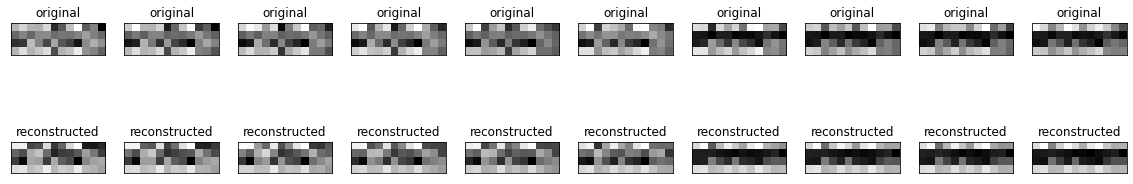

In [55]:
# encoded_imgs = shallow_encoder(df_test).numpy()
# decoded_imgs = shallow_decoder(encoded_imgs).numpy()
reconstructed_imgs = shallow_ae.predict(df_test).reshape(reshape_shape)
n = 10
offset=0
plt.figure(figsize=(20, 4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i+offset])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_imgs[i+offset])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


### Approach from online tutorial:

In [56]:
reshape_shape = (-1, *import_shape[1:])
print(reshape_shape)

x_train = df_train.to_numpy().reshape(reshape_shape)
x_val = df_val.to_numpy().reshape(reshape_shape)
x_test = df_test.to_numpy().reshape(reshape_shape)
print(x_train.shape, x_val.shape, x_test.shape)

(-1, 4, 12)
(12280, 4, 12) (3509, 4, 12) (1755, 4, 12)


In [77]:
latent_dim = 20

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim*2, activation='tanh'),
      layers.Dense(latent_dim, activation='tanh'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(x_train.shape[1]*x_train.shape[2]/2, activation='tanh'),
      layers.Dense(x_train.shape[1]*x_train.shape[2], activation='tanh'),
      layers.Reshape((x_train.shape[1], x_train.shape[2]))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [93]:
clear_session()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer=optimizer, loss="mae")
autoencoder.build(input_shape=x_train.shape)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (12280, 20)               2780      
                                                                 
 sequential_1 (Sequential)   (12280, 4, 12)            1704      
                                                                 
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________


In [94]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/20
384/384 [==============================] - 2s 3ms/step - loss: 0.3373 - val_loss: 0.2934
Epoch 2/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2904 - val_loss: 0.2879
Epoch 3/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2757 - val_loss: 0.2629
Epoch 4/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2713 - val_loss: 0.2626
Epoch 5/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2664 - val_loss: 0.2622
Epoch 6/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2642 - val_loss: 0.2605
Epoch 7/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2641 - val_loss: 0.2607
Epoch 8/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2602 - val_loss: 0.2517
Epoch 9/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2582 - val_loss: 0.2560
Epoch 10/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2550 - val_loss: 0.2530

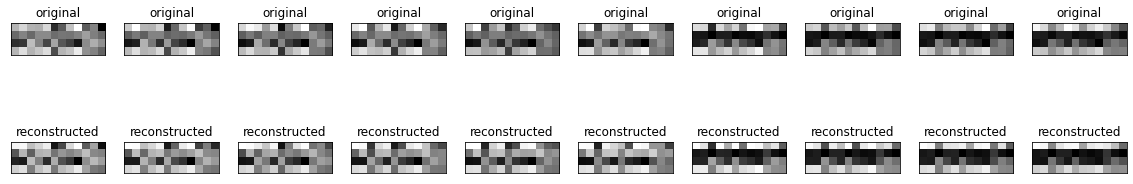

In [95]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
offset=0
plt.figure(figsize=(20, 4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i+offset])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i+offset])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
